In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
idx = pd.IndexSlice
pd.set_option("display.max_rows",101)
pd.set_option('expand_frame_repr', False)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# MRChem benchmark calculations

This notebook presents benchmark timings for the MRChem program on a set of molecular calculations using a variable number of CPU cores. The test systems are standard linear alkane chains $C_nH_{2n+2}$, with $n$ ranging from 2 to 350, as well as the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) and Valinomycine ($C_{54}H_{90}N_{6}O_{18}$) molecules. The main purpose of this data is to monitor the development of the code performance between different version, but it will also provide a reference for users to check if the code has been properly installed and runs reasonably on their system. Not all molecular systems will be available in the data, which mirrors the current limitations of the code when it comes to system size and numerical precision. Only a small selection of the data will be presented below, but further details are available by digging into the raw data.

## MRChem SCF cycle

The Self-Consistent Field (SCF) cycle in MRChem contains the following steps:

- Building Fock operator
- Calculating Fock matrix
- Rotating orbitals (diagonalization or localization)
- Calculating SCF energy
- Applying Helmholtz operator
- Applying iterative subspace acceleration (KAIN)
- Löwdin orthonormalization

and each of these may have sub steps that can be extracted from the data below. The calculations are performed using one of the following methods:

- Hartree (to show the performance of the backbone SCF algorithm + Coulomb interaction)
- Hartree-Fock (to show the performance of the exact exchange operator)
- DFT-PBE (to show the performance of the density functional integrator)

## Parallel performance

The following table presents timings (in sec) for the different parts of a single SCF cycle for the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) molecule at numerical precision $\epsilon=10^{-5}$, using the PBE density functional. The calculations are using an increasing number of MPI processes and OMP threads per process. The molecule has 102 electrons and 51 doubly occupied molecular orbitals.

In [2]:
mol='caffeine'
hybrid_frame = pd.read_csv("caffeine/scf.csv", index_col=[0,1,2])
hybrid_frame.loc[mol,:,:]

Localize  SCF energy  Helmholtz    Lowdin       KAIN  Fock operator  Fock matrix  Total SCF
MPI OMP                                                                                             
1   1    473.0840   518.01100  6369.0800   74.7940  49.206200       405.2480     635.6290   8566.960
    2    292.3700   270.72100  3215.4500   51.7344  28.228000       204.4420     360.6870   4455.010
    5    181.6300   127.58300  1381.4800   35.3990  16.369300        85.7853     210.1030   2063.320
    10   144.3730    81.49610   786.9080   31.2733  12.869400        48.0955     162.2130   1291.260
    16   131.6880    64.57680   573.6660   29.0997  12.093200        34.0539     129.8480    996.231
2   1    264.8690   263.22700  3253.4400   52.5945  24.430400       291.2850     334.9860   4516.560
    2    165.8500   139.56800  1643.0100   34.9136  14.189400       148.8010     195.8800   2365.250
    5    109.8390    68.79310   739.8050   25.4104   8.697160        65.6325     117.0090   1153.530
    10   100.1850    41.58510   401.1220   24.7811   6.700310        35.2339      93.4738    722.996
    20    89.4136    28.08250   234.9540   23.3857   5.683760        19.7715      80.5942    500.348
4   1    164.5260   143.17700  1682.3000  114.5710  14.250900       255.1930     188.8120   2588.860
    2    102.4110    74.55350   881.5590   38.6801   8.444910       130.4190     112.0960   1368.130
    5     72.1752    34.59620   374.7760   33.1285   5.088800        53.8603      67.8277    658.455
    10    54.6233    20.04060   192.4890   21.9166   3.493270        26.8814      47.2974    381.066
    20    56.2206    13.73520   116.5350   19.4080   3.316110        15.5909      45.3512    284.610
8   1     97.7182    75.99880   901.6980   63.3939   7.988990       219.1240     107.7680   1497.520
    2     68.0288    40.94640   475.9990   38.9602   4.533740       114.0220      70.3887    832.854
    5     44.0205    17.53720   190.4020   23.5377   2.407720        44.4628      40.5526    377.680
    10    36.7230    11.07200   104.4220   19.6878   1.912780        23.8500      32.2008    243.278
    20    36.8973     7.74457    64.1390   17.7631   1.646680        13.9284      30.0216    185.434
16  1     71.4947    40.75790   473.9070   83.6378   3.864350       198.4900      80.7477    977.726
    2     53.4706    22.63010   258.6180   51.8400   2.482230       105.5980      52.9709    568.498
    5     41.8001     9.67326   107.6280   31.8954   1.323020        41.0434      40.5890    294.340
    10    31.3309     6.39521    59.9725   22.6128   0.958419        21.7781      28.0190    186.441
    20    28.7354     4.11183    37.7202   17.6191   0.829354        13.0903      23.2072    138.621
32  1     63.1694    40.49900   200.2630  221.0590   9.367870       228.3700     107.1620    895.833
    2     47.0160    22.44700   110.8960  121.7900   5.688760       123.3940      69.8002    521.800
    5     36.6707    11.43510    51.0397   64.9468   3.586460        52.7680      46.8223    285.333
    10    29.9532     5.36126    30.7260   32.2609   1.976200        21.9720      27.9368    165.677
    20    27.2734     2.90582    20.9618   23.7123   1.213680        12.8683      24.2688    127.156

## OpenMP scaling

The following table presents timings (in sec) on a single compute node for the different parts of a single SCF cycle for the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) molecule at numerical precision $\epsilon=10^{-5}$, using the PBE density functional. The molecule has 102 electrons and 51 doubly occupied molecular orbitals.

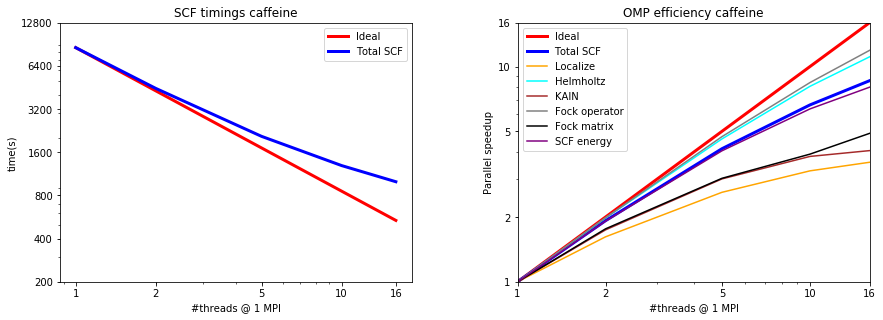

,Localize,SCF energy,Helmholtz,Lowdin,KAIN,Fock operator,Fock matrix,Total SCF
OMP,,,,,,,,
1,473.084,518.0110,6369.080,74.7940,49.2062,405.2480,635.629,8566.960
2,292.370,270.7210,3215.450,51.7344,28.2280,204.4420,360.687,4455.010
5,181.630,127.5830,1381.480,35.3990,16.3693,85.7853,210.103,2063.320
10,144.373,81.4961,786.908,31.2733,12.8694,48.0955,162.213,1291.260
16,131.688,64.5768,573.666,29.0997,12.0932,34.0539,129.848,996.231


In [21]:
mpi=1
mol='caffeine'
omp_frame = pd.read_csv("caffeine/scf.csv", index_col=[0,1,2])
omp_series = omp_frame.loc[mol,mpi]

plt.subplot(121)
plt.title('SCF timings ' + mol)
plt.plot(omp_series.index, mpi*omp_series['Total SCF'][mpi]/omp_series.index, c='red', lw=3, label='Ideal')
plt.plot(omp_series['Total SCF'], c='blue', lw=3, label='Total SCF')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.yticks([200, 400, 800, 1600, 3200, 6400, 12800], [200, 400, 800, 1600, 3200, 6400, 12800])
plt.xticks([1, 2, 5, 10, 16], [1, 2, 5, 10, 16])
plt.ylabel('time(s)')
plt.xlabel('#threads' + ' @ ' + str(mpi) + ' MPI')

plt.subplot(122)
plt.title('OMP efficiency ' + mol)
plt.plot(omp_series.index, omp_series.index, c='red', lw=3, label='Ideal')
plt.plot(mpi*omp_series['Total SCF'][mpi]/omp_series['Total SCF'], c='blue', lw=3, label='Total SCF')
plt.plot(mpi*omp_series['Localize'][mpi]/omp_series['Localize'], c='orange', label='Localize')
plt.plot(mpi*omp_series['Helmholtz'][mpi]/omp_series['Helmholtz'], c='cyan', label='Helmholtz')
plt.plot(mpi*omp_series['KAIN'][mpi]/omp_series['KAIN'], c='brown', label='KAIN')
plt.plot(mpi*omp_series['Fock operator'][mpi]/omp_series['Fock operator'], c='gray', label='Fock operator')
plt.plot(mpi*omp_series['Fock matrix'][mpi]/omp_series['Fock matrix'], c='black', label='Fock matrix')
plt.plot(mpi*omp_series['SCF energy'][mpi]/omp_series['SCF energy'], c='purple', label='SCF energy')
plt.legend(loc='upper left')
plt.axis([1, 16, 1, 16])
plt.yscale('log')
plt.xscale('log')
plt.yticks([1, 2, 5, 10, 16], [1, 2, 5, 10, 16])
plt.xticks([1, 2, 5, 10, 16], [1, 2, 5, 10, 16])
plt.ylabel('Parallel speedup')
plt.xlabel('#threads' + ' @ ' + str(mpi) + ' MPI')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
omp_frame.loc[mol,mpi,:]

## MPI scaling

The following table presents timings (in sec) for the different parts of a single SCF cycle for the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) molecule at numerical precision $\epsilon=10^{-5}$, using the PBE density functional. The calculations are using an increasing number of MPI processes with fixed a single OMP threads per process. The molecule has 102 electrons and 51 doubly occupied molecular orbitals.

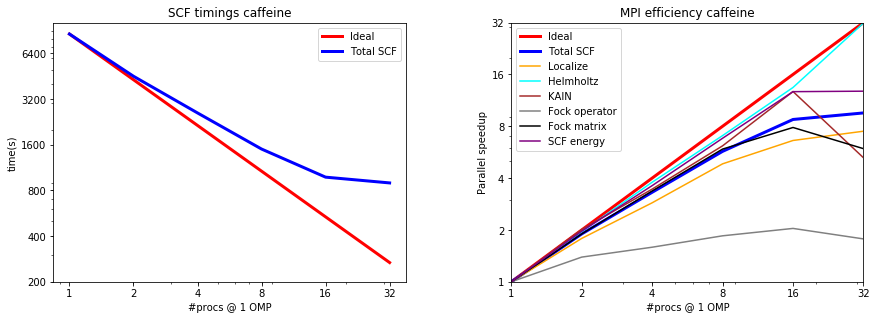

,Localize,SCF energy,Helmholtz,Lowdin,KAIN,Fock operator,Fock matrix,Total SCF
MPI,,,,,,,,
1,473.0840,518.0110,6369.080,74.7940,49.20620,405.248,635.6290,8566.960
2,264.8690,263.2270,3253.440,52.5945,24.43040,291.285,334.9860,4516.560
4,164.5260,143.1770,1682.300,114.5710,14.25090,255.193,188.8120,2588.860
8,97.7182,75.9988,901.698,63.3939,7.98899,219.124,107.7680,1497.520
16,71.4947,40.7579,473.907,83.6378,3.86435,198.490,80.7477,977.726
32,63.1694,40.4990,200.263,221.0590,9.36787,228.370,107.1620,895.833


In [20]:
omp=1
ref=1
mol='caffeine'
mpi_frame = pd.read_csv("caffeine/scf.csv", index_col=[0,2,1])
mpi_series = mpi_frame.loc[mol,omp]

plt.subplot(121)
plt.title('SCF timings ' + mol)
plt.plot(mpi_series.index, ref*mpi_series['Total SCF'][ref]/mpi_series.index, c='red', lw=3, label='Ideal')
plt.plot(mpi_series['Total SCF'], c='blue', lw=3, label='Total SCF')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.yticks([200, 400, 800, 1600, 3200, 6400], [200, 400, 800, 1600, 3200, 6400])
plt.xticks([1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32])
plt.ylabel('time(s)')
plt.xlabel('#procs' + ' @ ' + str(omp) + ' OMP')

plt.subplot(122)
plt.title('MPI efficiency ' + mol)
plt.plot(mpi_series.index, mpi_series.index, c='red', lw=3, label='Ideal')
plt.plot(ref*mpi_series['Total SCF'][ref]/mpi_series['Total SCF'], c='blue', lw=3, label='Total SCF')
plt.plot(ref*mpi_series['Localize'][ref]/mpi_series['Localize'], c='orange', label='Localize')
plt.plot(ref*mpi_series['Helmholtz'][ref]/mpi_series['Helmholtz'], c='cyan', label='Helmholtz')
plt.plot(ref*mpi_series['KAIN'][ref]/mpi_series['KAIN'], c='brown', label='KAIN')
plt.plot(ref*mpi_series['Fock operator'][ref]/mpi_series['Fock operator'], c='gray', label='Fock operator')
plt.plot(ref*mpi_series['Fock matrix'][ref]/mpi_series['Fock matrix'], c='black', label='Fock matrix')
plt.plot(ref*mpi_series['SCF energy'][ref]/mpi_series['SCF energy'], c='purple', label='SCF energy')
plt.legend(loc='upper left')
plt.yscale('log')
plt.xscale('log')
plt.axis([1,32,1,32])
plt.yticks([1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32])
plt.xticks([1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32])
plt.ylabel('Parallel speedup')
plt.xlabel('#procs' + ' @ ' + str(omp) + ' OMP')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
mpi_frame.loc[mol,omp]

## Hybrid MPI/OpenMP scaling

The following table presents timings (in sec) for the different parts of a single SCF cycle for the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) molecule at numerical precision $\epsilon=10^{-5}$, using the PBE density functional. The calculations are using an increasing number of MPI processes with fixed 10 OMP threads per process. The molecule has 102 electrons and 51 doubly occupied molecular orbitals.

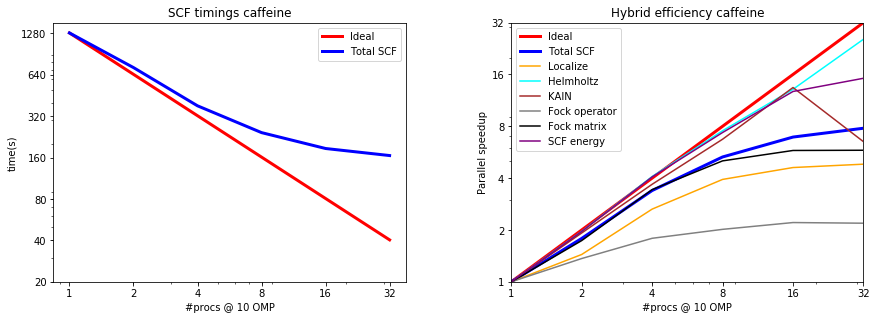

,Localize,SCF energy,Helmholtz,Lowdin,KAIN,Fock operator,Fock matrix,Total SCF
MPI,,,,,,,,
1,144.3730,81.49610,786.9080,31.2733,12.869400,48.0955,162.2130,1291.260
2,100.1850,41.58510,401.1220,24.7811,6.700310,35.2339,93.4738,722.996
4,54.6233,20.04060,192.4890,21.9166,3.493270,26.8814,47.2974,381.066
8,36.7230,11.07200,104.4220,19.6878,1.912780,23.8500,32.2008,243.278
16,31.3309,6.39521,59.9725,22.6128,0.958419,21.7781,28.0190,186.441
32,29.9532,5.36126,30.7260,32.2609,1.976200,21.9720,27.9368,165.677


In [31]:
omp=10
ref=1
mol='caffeine'
hybrid_frame = pd.read_csv("caffeine/scf.csv", index_col=[0,2,1])
hybrid_series = hybrid_frame.loc[mol,omp]

plt.subplot(121)
plt.title('SCF timings ' + mol)
plt.plot(hybrid_series.index, ref*hybrid_series['Total SCF'][ref]/hybrid_series.index, c='red', lw=3, label='Ideal')
plt.plot(hybrid_series['Total SCF'], c='blue', lw=3, label='Total SCF')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.yticks([20, 40, 80, 160, 320, 640, 1280], [20, 40, 80, 160, 320, 640, 1280])
plt.xticks([1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32])
plt.ylabel('time(s)')
plt.xlabel('#procs' + ' @ ' + str(omp) + ' OMP')

plt.subplot(122)
plt.title('Hybrid efficiency ' + mol)
plt.plot(hybrid_series.index, hybrid_series.index, c='red', lw=3, label='Ideal')
plt.plot(ref*hybrid_series['Total SCF'][ref]/hybrid_series['Total SCF'], c='blue', lw=3, label='Total SCF')
plt.plot(ref*hybrid_series['Localize'][ref]/hybrid_series['Localize'], c='orange', label='Localize')
plt.plot(ref*hybrid_series['Helmholtz'][ref]/hybrid_series['Helmholtz'], c='cyan', label='Helmholtz')
plt.plot(ref*hybrid_series['KAIN'][ref]/hybrid_series['KAIN'], c='brown', label='KAIN')
plt.plot(ref*hybrid_series['Fock operator'][ref]/hybrid_series['Fock operator'], c='gray', label='Fock operator')
plt.plot(ref*hybrid_series['Fock matrix'][ref]/hybrid_series['Fock matrix'], c='black', label='Fock matrix')
plt.plot(ref*hybrid_series['SCF energy'][ref]/hybrid_series['SCF energy'], c='purple', label='SCF energy')
plt.legend(loc='upper left')
plt.yscale('log')
plt.xscale('log')
plt.axis([1,32,1,32])
plt.yticks([1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32])
plt.xticks([1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32])
plt.ylabel('Parallel speedup')
plt.xlabel('#procs' + ' @ ' + str(omp) + ' OMP')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
mpi_frame.loc[mol,omp,:]